<a href="https://colab.research.google.com/github/bbbymrphy/Algorithms-for-Data-Science-FALL-2025-72720/blob/main/california_housing_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

data = pd.read_csv('/content/sample_data/california_housing_train.csv')
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


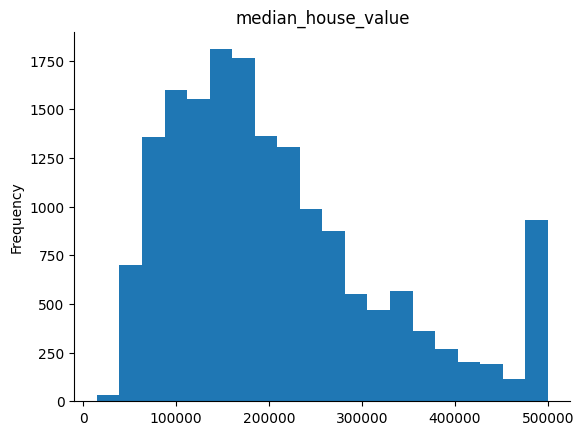

In [ ]:
# @title median_house_value

from matplotlib import pyplot as plt
data['median_house_value'].plot(kind='hist', bins=20, title='median_house_value')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
data.columns


Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value'],
      dtype='object')

Test R^2 : 0.6636
Test MAE : 49,983.47
Test RMSE: 68,078.33

5-fold CV R^2  :  [0.522  0.5643 0.6026 0.3968 0.6558]  | mean = 0.5483
5-fold CV RMSE :  [71297.2  60203.85 87588.76 69088.44 74892.16]  | mean = 72614.08

Standardized Coefficients (larger magnitude = stronger effect):
              feature  coef_standardized
0            latitude      -91983.102014
1           longitude      -87098.433836
2       median_income       76754.043069
3      total_bedrooms       47893.657219
4          population      -41374.290581
5         total_rooms      -19175.064162
6          households       17328.745023
7  housing_median_age       14256.837611


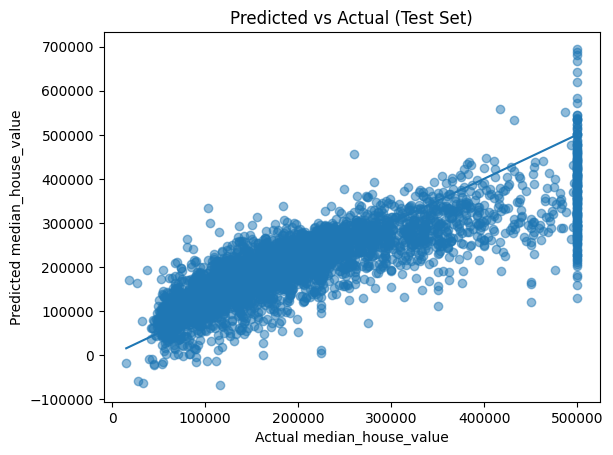

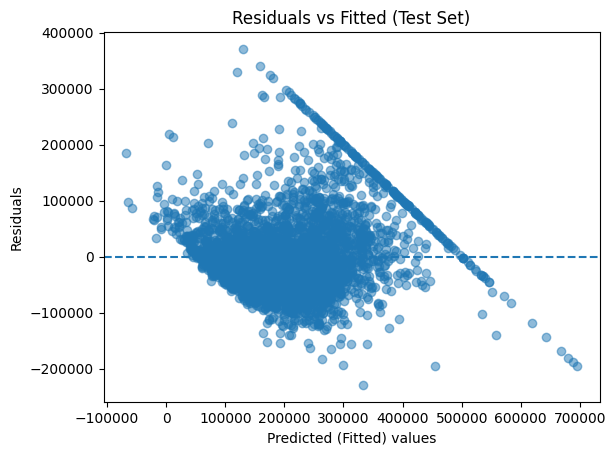

In [ ]:
# quick_linear_regression_housing.py
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# 1) Load your data ------------------------------------------------------------
# Replace with your file path
df = data

# Ensure expected columns exist
expected = [
    'longitude','latitude','housing_median_age','total_rooms',
    'total_bedrooms','population','households','median_income','median_house_value'
]
missing = [c for c in expected if c not in df.columns]
if missing:
    raise ValueError(f"Missing expected columns: {missing}")

# 2) Split features/target -----------------------------------------------------
target = 'median_house_value'
feature_cols = [c for c in expected if c != target]
X = df[feature_cols].copy()
y = df[target].astype(float).copy()

# 3) Train/test split ----------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 4) Build a simple linear regression pipeline --------------------------------
# - Impute missing values with medians
# - Standardize features (not required for LinearRegression, but makes coefs comparable)
linreg_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("model", LinearRegression())
])

# (Optional) Swap in Ridge for a touch of regularization if needed:
# linreg_pipe = Pipeline(steps=[
#     ("imputer", SimpleImputer(strategy="median")),
#     ("scaler", StandardScaler(with_mean=True, with_std=True)),
#     ("model", Ridge(alpha=1.0, random_state=42))
# ])

# 5) Fit -----------------------------------------------------------------------
linreg_pipe.fit(X_train, y_train)

# 6) Evaluate on test set ------------------------------------------------------
y_pred = linreg_pipe.predict(X_test)

r2  = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
cv_rmse = np.sqrt(-cross_val_score(linreg_pipe, X, y, scoring="neg_mean_squared_error", cv=5))

print(f"Test R^2 : {r2:.4f}")
print(f"Test MAE : {mae:,.2f}")
print(f"Test RMSE: {rmse:,.2f}")

# 7) Cross-validation (optional, quick sanity check) ---------------------------
cv_r2   = cross_val_score(linreg_pipe, X, y, scoring="r2", cv=5)
cv_rmse = -cross_val_score(linreg_pipe, X, y, scoring="neg_root_mean_squared_error", cv=5)

print("\n5-fold CV R^2  : ", np.round(cv_r2, 4), " | mean =", cv_r2.mean().round(4))
print("5-fold CV RMSE : ", np.round(cv_rmse, 2), " | mean =", cv_rmse.mean().round(2))

# 8) Coefficients (standardized feature effects) -------------------------------
# These are in standardized units (because we scaled); good for comparing importance
model = linreg_pipe.named_steps["model"]

coef_table = (
    pd.DataFrame({
        "feature": feature_cols,
        "coef_standardized": model.coef_
    })
    .assign(abs_coef=lambda d: d["coef_standardized"].abs())
    .sort_values("abs_coef", ascending=False)
    .drop(columns="abs_coef")
    .reset_index(drop=True)
)

print("\nStandardized Coefficients (larger magnitude = stronger effect):")
print(coef_table)

# 9) Quick diagnostics (optional plots) ----------------------------------------
# Predicted vs Actual
plt.figure()
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual median_house_value")
plt.ylabel("Predicted median_house_value")
plt.title("Predicted vs Actual (Test Set)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()])
plt.show()

# Residuals vs Fitted
residuals = y_test - y_pred
plt.figure()
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, linestyle="--")
plt.xlabel("Predicted (Fitted) values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted (Test Set)")
plt.show()


Correlation matrix (Pearson):
                    longitude  latitude  housing_median_age  total_rooms  \
longitude               1.000    -0.925              -0.114        0.047   
latitude               -0.925     1.000               0.016       -0.039   
housing_median_age     -0.114     0.016               1.000       -0.361   
total_rooms             0.047    -0.039              -0.361        1.000   
total_bedrooms          0.072    -0.069              -0.320        0.928   
population              0.102    -0.111              -0.296        0.860   
households              0.060    -0.075              -0.303        0.919   
median_income          -0.015    -0.080              -0.116        0.195   
median_house_value     -0.045    -0.145               0.107        0.131   

                    total_bedrooms  population  households  median_income  \
longitude                    0.072       0.102       0.060         -0.015   
latitude                    -0.069      -0.111      -0.

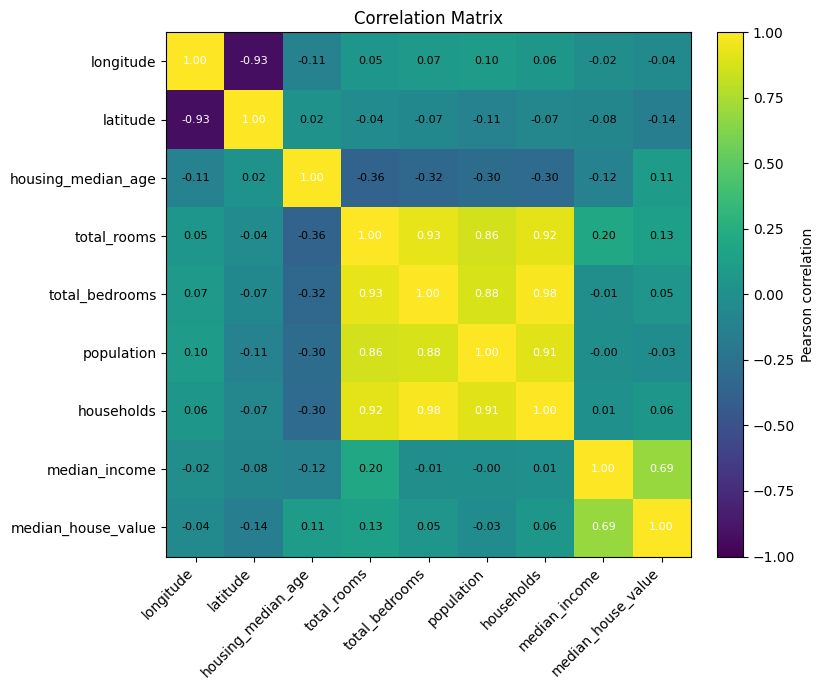

In [ ]:
cols = df.columns

# 1) Correlation matrix (Pearson; pairwise handling of NaNs)
corr = df[cols].corr(method='pearson')
print("Correlation matrix (Pearson):")
print(corr.round(3))

# 2) Save to CSV (optional)
#corr.to_csv("correlation_matrix.csv")

# 3) Correlation with the target only
target_corr = corr['median_house_value'].sort_values(ascending=False)
print("\nCorrelation with median_house_value:")
print(target_corr.round(3))

# 4) Heatmap (matplotlib only; no seaborn)
fig, ax = plt.subplots(figsize=(8.5, 7))
im = ax.imshow(corr.values, vmin=-1, vmax=1)
ax.set_xticks(np.arange(len(cols)))
ax.set_yticks(np.arange(len(cols)))
ax.set_xticklabels(cols, rotation=45, ha='right')
ax.set_yticklabels(cols)
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Pearson correlation')

# Annotate each cell
for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        val = corr.values[i, j]
        ax.text(j, i, f"{val:.2f}",
                ha="center", va="center",
                fontsize=8,
                color=("white" if abs(val) >= 0.5 else "black"))

plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

# (Optional) Spearman rank correlations (more robust to nonlinearity/outliers)
spearman_corr = df[cols].corr(method='spearman')
# spearman_corr.to_csv("correlation_matrix_spearman.csv")

=== Baseline (no spatial features) ===
Test -> R^2: 0.6636 | MAE: 49,983.47 | RMSE: 68,078.33
Moran's I (train residuals): 0.4691 | p+ (pos. autocorr): 0.0010 | p(two-sided): 0.0020

=== With spatial k-NN features ===
Test -> R^2: 0.8583 | MAE: 28,777.04 | RMSE: 44,179.38
Moran's I (train residuals, spatial model): -0.0488 | p+ (pos. autocorr): 1.0000 | p(two-sided): 0.0020


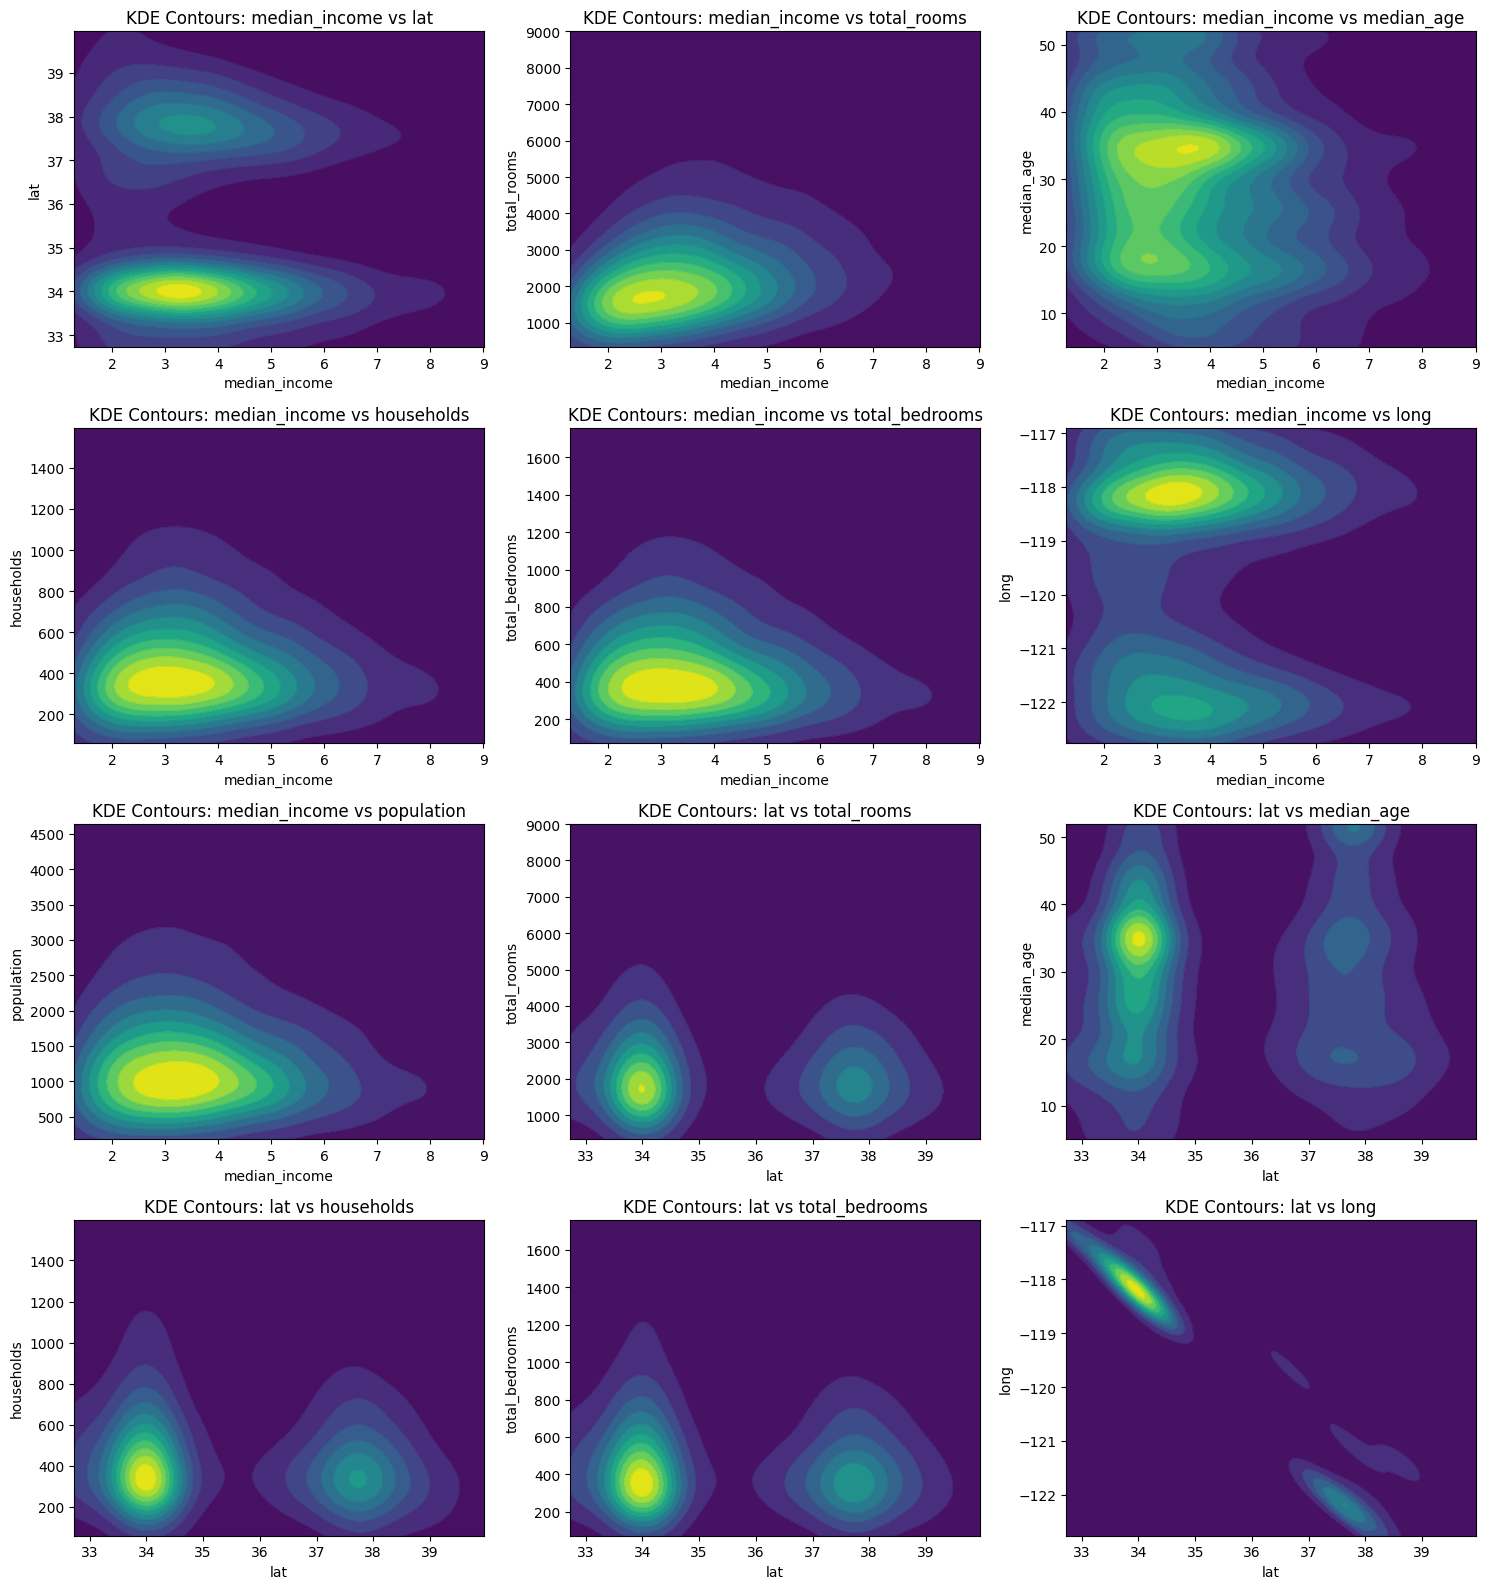

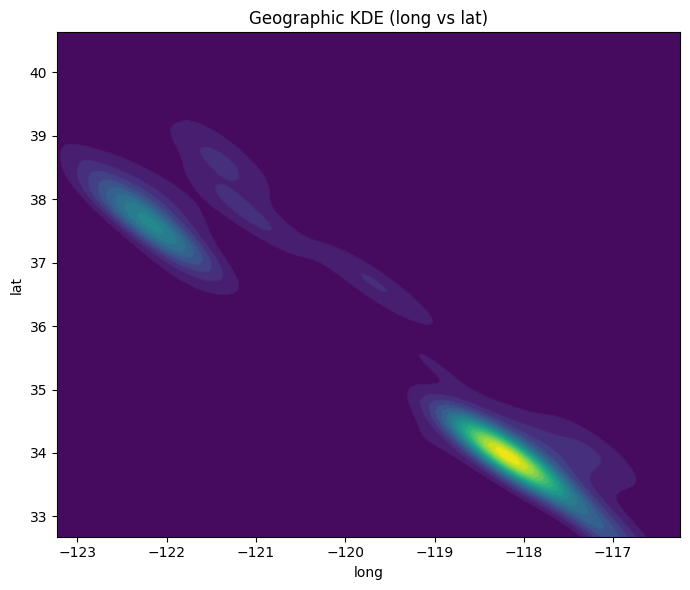

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations

# Optional fallback if SciPy isn't installed
try:
    from scipy.stats import gaussian_kde
    _HAS_SCIPY = True
except Exception:
    _HAS_SCIPY = False
    from sklearn.neighbors import KernelDensity
    from sklearn.preprocessing import StandardScaler

# -----------------------------
# 0) Expect a DataFrame `df`
# -----------------------------
# df = pd.read_csv("path/to/your_housing.csv")

# Handle column aliases (use whichever you’ve got)
alias_map = {
    'longitude': 'long',
    'latitude': 'lat',
    'housing_median_age': 'median_age'
}
for old, new in alias_map.items():
    if old in df.columns and new not in df.columns:
        df = df.rename(columns={old: new})

# -----------------------------
# 1) Choose features
# -----------------------------
target = 'median_house_value'
# take numeric columns and exclude the target
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
features_all = [c for c in num_cols if c != target]

# If you want a curated subset, uncomment and edit:
# features_all = ['long','lat','median_age','median_income','total_rooms','total_bedrooms','population','households']

# -----------------------------
# 2) 2D KDE helper
# -----------------------------
def kde2d_grid(x, y, gridsize=120, cut=0.02, seed=0):
    """
    Returns (Xg, Yg, Z) where Z is KDE density on a meshgrid.
    - Percentile 'cut' trims tails to avoid huge empty margins.
    """
    x = np.asarray(x, float)
    y = np.asarray(y, float)
    mask = np.isfinite(x) & np.isfinite(y)
    x, y = x[mask], y[mask]

    if x.size < 10 or np.std(x) == 0 or np.std(y) == 0:
        return None, None, None  # not enough variation to estimate

    # Bounds via central percentiles
    xlo, xhi = np.percentile(x, [100*cut, 100*(1-cut)])
    ylo, yhi = np.percentile(y, [100*cut, 100*(1-cut)])
    if not np.isfinite([xlo, xhi, ylo, yhi]).all() or xlo >= xhi or ylo >= yhi:
        return None, None, None

    xs = np.linspace(xlo, xhi, gridsize)
    ys = np.linspace(ylo, yhi, gridsize)
    Xg, Yg = np.meshgrid(xs, ys)
    XY = np.vstack([Xg.ravel(), Yg.ravel()])

    if _HAS_SCIPY:
        # SciPy gaussian_kde with Scott’s rule (default)
        kde = gaussian_kde(np.vstack([x, y]))
        Z = kde(XY).reshape(Xg.shape)
    else:
        # Fallback: sklearn KDE. Standardize to make single bandwidth sensible.
        scaler = StandardScaler().fit(np.c_[x, y])
        XYs = scaler.transform(np.c_[x, y])
        kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(XYs)
        grid_std = scaler.transform(XY.T)
        Z = np.exp(kde.score_samples(grid_std)).reshape(Xg.shape)

    return Xg, Yg, Z

# -----------------------------
# 3) Pick pairs to plot
#     (default: top pairs by |corr| with target to keep it concise)
# -----------------------------
def pick_top_pairs(df, features, target, max_pairs=12):
    # choose features most related to target, then make pairs among them
    corr = df[features + [target]].corr(method='pearson')[target].drop(labels=[target]).abs()
    top_feats = corr.sort_values(ascending=False).index.tolist()
    # widen coverage but cap total pairs
    candidate_pairs = list(combinations(top_feats, 2))
    return candidate_pairs[:max_pairs]

pairs = pick_top_pairs(df, features_all, target, max_pairs=12)

# If you want *all* pairs (could be a lot!), use:
# pairs = list(combinations(features_all, 2))

# -----------------------------
# 4) Plotting
# -----------------------------
def plot_kde_contours(df, pairs, ncols=3, gridsize=120, cut=0.02):
    n = len(pairs)
    if n == 0:
        raise ValueError("No feature pairs to plot.")

    ncols = max(1, int(ncols))
    nrows = int(np.ceil(n / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
    if nrows == 1 and ncols == 1:
        axes = np.array([[axes]])
    elif nrows == 1:
        axes = np.array([axes])
    elif ncols == 1:
        axes = axes[:, None]

    idx = 0
    for r in range(nrows):
        for c in range(ncols):
            ax = axes[r, c]
            if idx >= n:
                ax.axis('off')
                continue

            f1, f2 = pairs[idx]
            x = df[f1].values
            y = df[f2].values

            Xg, Yg, Z = kde2d_grid(x, y, gridsize=gridsize, cut=cut)
            if Z is None:
                ax.text(0.5, 0.5, f"Insufficient variance\n{f1} vs {f2}",
                        ha='center', va='center', transform=ax.transAxes)
                ax.set_axis_off()
            else:
                # Filled contours + contour lines
                cf = ax.contourf(Xg, Yg, Z, levels=12)  # no explicit colors
                ax.contour(Xg, Yg, Z, levels=12, linewidths=0.6)

                # Optional: overlay a light scatter sample for context
                # samp = np.random.default_rng(0).choice(len(df), size=min(1000, len(df)), replace=False)
                # ax.scatter(df[f1].values[samp], df[f2].values[samp], s=3, alpha=0.2)

                ax.set_xlabel(f1)
                ax.set_ylabel(f2)
                ax.set_title(f"KDE Contours: {f1} vs {f2}")

            idx += 1

    plt.tight_layout()
    plt.show()

# -----------------------------
# 5) Run it
# -----------------------------
plot_kde_contours(df, pairs, ncols=3, gridsize=140, cut=0.02)

# -----------------------------
# (Optional) A dedicated map-like KDE for geography
# -----------------------------
if {'long','lat'}.issubset(df.columns):
    Xg, Yg, Z = kde2d_grid(df['long'], df['lat'], gridsize=250, cut=0.01)
    if Z is not None:
        plt.figure(figsize=(7, 6))
        plt.contourf(Xg, Yg, Z, levels=20)
        plt.contour(Xg, Yg, Z, levels=20, linewidths=0.6)
        plt.xlabel("long")
        plt.ylabel("lat")
        plt.title("Geographic KDE (long vs lat)")
        plt.tight_layout()
        plt.show()


=== Gradient Boosted Regression (baseline) ===
Train -> R^2: 0.8307 | MAE: 33,203.17 | RMSE: 47,573.74
Test  -> R^2: 0.8047 | MAE: 35,387.71 | RMSE: 51,879.27

5-fold CV RMSE: [91777.09 54039.19 83696.67 54135.91 77014.24] | mean = 72132.62

Top feature importances:
median_income     0.577184
lat               0.156194
long              0.137936
median_age        0.051561
total_bedrooms    0.027211
population        0.026744
households        0.015585
total_rooms       0.007585
dtype: float64


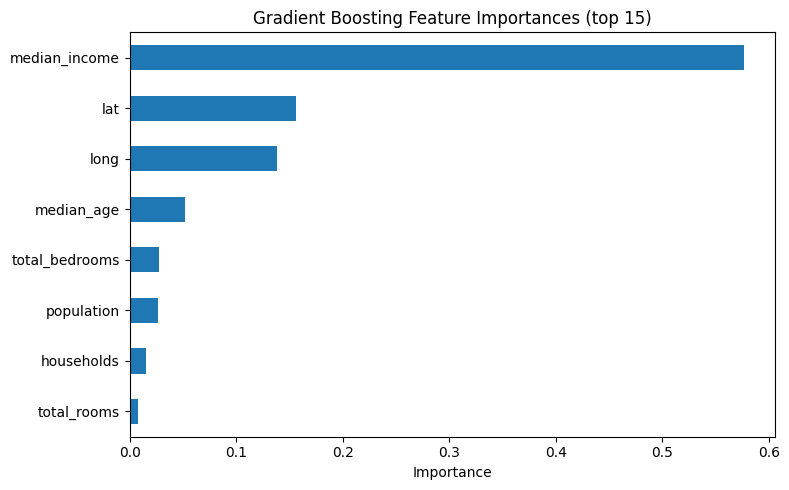

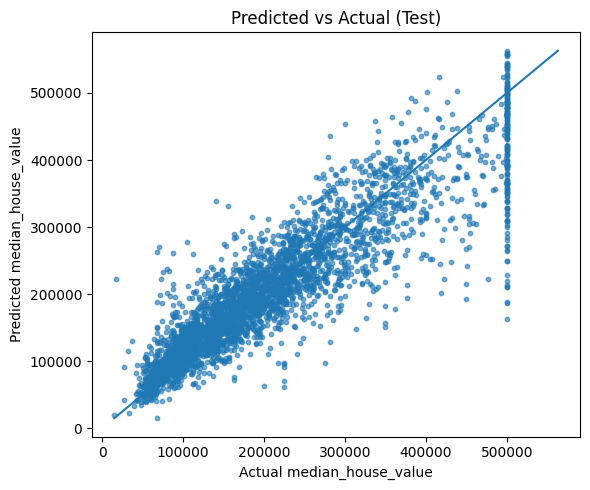

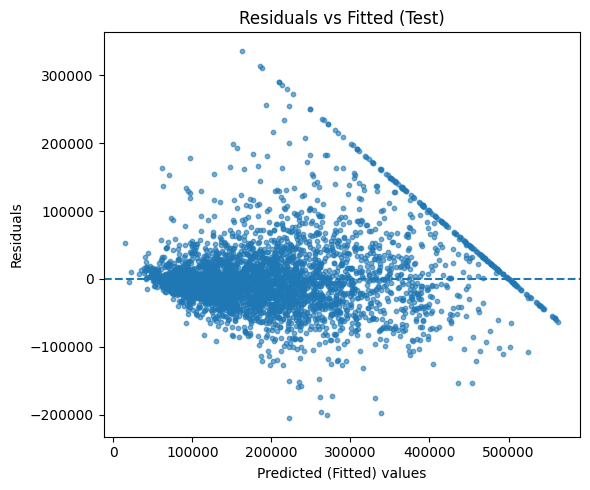

In [ ]:
# gradient_boosted_regression_housing.py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from pprint import pprint

# -----------------------------------------------------------------------------------
# 0) Load or use existing DataFrame `df`
# -----------------------------------------------------------------------------------
try:
    df  # if already in memory, use it
except NameError:
    # Replace with your path if loading from CSV
    df = pd.read_csv("path/to/your_housing.csv")

# Accept either original or aliased column names
rename_map = {
    'longitude': 'long',
    'latitude': 'lat',
    'housing_median_age': 'median_age'
}
for old, new in rename_map.items():
    if old in df.columns and new not in df.columns:
        df = df.rename(columns={old: new})

expected = [
    'long','lat','median_age','total_rooms','total_bedrooms',
    'population','households','median_income','median_house_value'
]
missing = [c for c in expected if c not in df.columns]
if missing:
    raise ValueError(f"Missing expected columns: {missing}")

# -----------------------------------------------------------------------------------
# 1) Features / target
# -----------------------------------------------------------------------------------
target = 'median_house_value'
feature_cols = [c for c in expected if c != target]

X = df[feature_cols].copy()
y = df[target].astype(float).copy()

# (Optional) simple feature engineering — uncomment if you want a quick lift
# X = X.assign(
#     rooms_per_household = df['total_rooms'] / (df['households'] + 1e-9),
#     bedrooms_per_room   = df['total_bedrooms'] / (df['total_rooms'] + 1e-9),
#     pop_per_household   = df['population'] / (df['households'] + 1e-9)
# )

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -----------------------------------------------------------------------------------
# 2) Pipeline: Impute -> GradientBoostingRegressor
# (Trees don't need scaling; imputation handles NaNs.)
# -----------------------------------------------------------------------------------
gbr_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("model", GradientBoostingRegressor(
        random_state=42,
        # Reasonable defaults; we’ll optionally tune below
        n_estimators=300,
        learning_rate=0.06,
        max_depth=3,
        subsample=0.8,
    ))
])

# -----------------------------------------------------------------------------------
# 3) Fit & evaluate
# -----------------------------------------------------------------------------------
gbr_pipe.fit(X_train, y_train)

def report_metrics(name, y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{name} -> R^2: {r2:.4f} | MAE: {mae:,.2f} | RMSE: {rmse:,.2f}")

y_pred_train = gbr_pipe.predict(X_train)
y_pred_test  = gbr_pipe.predict(X_test)

print("=== Gradient Boosted Regression (baseline) ===")
report_metrics("Train", y_train, y_pred_train)
report_metrics("Test ", y_test,  y_pred_test)

# Cross-validated RMSE (5-fold)
cv_rmse = np.sqrt(-cross_val_score(gbr_pipe, X, y, scoring="neg_mean_squared_error", cv=5))
print("\n5-fold CV RMSE:", np.round(cv_rmse, 2), "| mean =", np.round(cv_rmse.mean(), 2))

# -----------------------------------------------------------------------------------
# 4) Feature importances
# -----------------------------------------------------------------------------------
model = gbr_pipe.named_steps["model"]
importances = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print("\nTop feature importances:")
print(importances.head(12))

# Optional: quick bar plot
plt.figure(figsize=(8, 5))
importances.head(15).iloc[::-1].plot(kind="barh")
plt.title("Gradient Boosting Feature Importances (top 15)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------------
# 5) Diagnostics (optional)
# -----------------------------------------------------------------------------------
# Predicted vs Actual (test)
plt.figure(figsize=(6, 5))
plt.scatter(y_test, y_pred_test, s=10, alpha=0.6)
lims = [min(y_test.min(), y_pred_test.min()), max(y_test.max(), y_pred_test.max())]
plt.plot(lims, lims)
plt.xlabel("Actual median_house_value")
plt.ylabel("Predicted median_house_value")
plt.title("Predicted vs Actual (Test)")
plt.tight_layout()
plt.show()

# Residuals vs Fitted (test)
resid = y_test - y_pred_test
plt.figure(figsize=(6, 5))
plt.scatter(y_pred_test, resid, s=10, alpha=0.6)
plt.axhline(0, linestyle="--")
plt.xlabel("Predicted (Fitted) values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted (Test)")
plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------------
# 6) (Optional) Hyperparameter search for a better model
# -----------------------------------------------------------------------------------
# Uses RandomizedSearchCV with simple value grids (no SciPy required).
param_dist = {
    "model__n_estimators":   [200, 300, 500, 800],
    "model__learning_rate":  [0.04, 0.06, 0.08, 0.1],
    "model__max_depth":      [2, 3, 4, 5],
    "model__min_samples_split": [2, 4, 8, 16],
    "model__min_samples_leaf":  [1, 3, 5, 10, 20],
    "model__subsample":      [0.6, 0.7, 0.8, 0.9],
    "model__max_features":   [None, "sqrt", 0.6, 0.8],
}

search = RandomizedSearchCV(
    estimator=gbr_pipe,
    param_distributions=param_dist,
    n_iter=25,
    scoring="neg_mean_squared_error",  # we'll take sqrt later
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)
# Uncomment to run:
# search.fit(X_train, y_train)
# print("\nBest params:")
# pprint(search.best_params_)
# best_pipe = search.best_estimator_
# y_pred_test_best = best_pipe.predict(X_test)
# print("\n=== Tuned Gradient Boosting ===")
# report_metrics("Test (tuned)", y_test, y_pred_test_best)

